# **Digits Detection of License Plate Number**
In this notebook we will build tensorflow model to recognize each digits of a license plate number. We will use **Tensorflow Object Detection API** and **EfficientDet D1 640x640**.

Here is step by step building digits detection model.

In [ ]:
# Install GPU
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 --upgrade

# 0. Setup Paths

After completing this part, your directory tree will looks like below.

```
Tensorflow/
|--workspace
|  |--annotations
|  |--images
|  |--models
|  |--pre-trained-models
|--scripts
|--models
|--protoc
```


In [ ]:
# Mount your drive to colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
BASE_PATH = '/content/gdrive/MyDrive/Bangkit Project/Machine Learning/Digit Classification/' # edit into your path to Digits Classification
%cd {BASE_PATH}

/content/gdrive/MyDrive/Bangkit Project/Machine Learning/Digit Classification


In [ ]:
import os

In [ ]:
CUSTOM_MODEL_NAME = 'efficientdet_d1' 
PRETRAINED_MODEL_NAME = 'efficientdet_d1_coco17_tpu-32'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [ ]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [ ]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into 'Tensorflow/models'...
remote: Enumerating objects: 57179, done.
remote: Counting objects: 100% (1267/1267), done.
remote: Compressing objects: 100% (471/471), done.
remote: Total 57179 (delta 878), reused 1147 (delta 781), pack-reused 55912
Receiving objects: 100% (57179/57179), 572.80 MiB | 23.43 MiB/s, done.
Resolving deltas: 100% (39525/39525), done.
Checking out files: 100% (2451/2451), done.


In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

Don't worry if you see some error while installing some dependencies for Tensorflow Object Detection. It doesn't mean you failed to install Tensorflow Object Detection. 

You will verify the installation with codes below. If it say "OK" at the end, then you are successfully install Tensorflow Object Detection :)

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2021-05-21 00:34:59.003014: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-05-21 00:35:01.179151: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-05-21 00:35:01.239371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-21 00:35:01.239957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-05-21 00:35:01.239992: I tensorflow/stream_executor/platform/default/dso_loader.cc:5

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2021-05-21 00:41:27--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.79.128, 2a00:1450:4013:c05::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.79.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  53.2MB/s    in 4.4s    

2021-05-21 00:41:33 (53.2 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]

ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_resnet

# 2. Create Label Map

Tensorflow requires a label map, which maps each of the used labels to an integer. This label map will be used in the training and detection processes.

In [ ]:
import string

labels = []
i = 1
for char in string.ascii_uppercase:
  tmp = {'name': char, 'id': i}
  labels.append(tmp)
  i += 1

for num in range(0,10):
  tmp = {'name': str(num), 'id': i}
  labels.append(tmp)
  i += 1

print(labels)

[{'name': 'A', 'id': 1}, {'name': 'B', 'id': 2}, {'name': 'C', 'id': 3}, {'name': 'D', 'id': 4}, {'name': 'E', 'id': 5}, {'name': 'F', 'id': 6}, {'name': 'G', 'id': 7}, {'name': 'H', 'id': 8}, {'name': 'I', 'id': 9}, {'name': 'J', 'id': 10}, {'name': 'K', 'id': 11}, {'name': 'L', 'id': 12}, {'name': 'M', 'id': 13}, {'name': 'N', 'id': 14}, {'name': 'O', 'id': 15}, {'name': 'P', 'id': 16}, {'name': 'Q', 'id': 17}, {'name': 'R', 'id': 18}, {'name': 'S', 'id': 19}, {'name': 'T', 'id': 20}, {'name': 'U', 'id': 21}, {'name': 'V', 'id': 22}, {'name': 'W', 'id': 23}, {'name': 'X', 'id': 24}, {'name': 'Y', 'id': 25}, {'name': 'Z', 'id': 26}, {'name': '0', 'id': 27}, {'name': '1', 'id': 28}, {'name': '2', 'id': 29}, {'name': '3', 'id': 30}, {'name': '4', 'id': 31}, {'name': '5', 'id': 32}, {'name': '6', 'id': 33}, {'name': '7', 'id': 34}, {'name': '8', 'id': 35}, {'name': '9', 'id': 36}]


In [ ]:
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

You can download the license plate dataset [here](https://drive.google.com/file/d/1NYhjCG4BUJeZlRKI2cO1x-Fd9iPiv0-v/view?usp=sharing). Then upload it to `Tensorflow/workspace/images/`.



In [ ]:
# OPTIONAL IF RUNNING ON COLAB
# Unzip dataset
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

Tensorflow/workspace/images/train/
Tensorflow/workspace/images/train/1.E 3977 QM-09-19.jpeg
Tensorflow/workspace/images/train/1.E 3977 QM-09-19.xml
Tensorflow/workspace/images/train/11.E 6562 QO-12-19.jpeg
Tensorflow/workspace/images/train/11.E 6562 QO-12-19.xml
Tensorflow/workspace/images/train/12.E 2462 QF-02-19.jpeg
Tensorflow/workspace/images/train/12.E 2462 QF-02-19.xml
Tensorflow/workspace/images/train/13.E 5313 TF-10-16.jpeg
Tensorflow/workspace/images/train/13.E 5313 TF-10-16.xml
Tensorflow/workspace/images/train/14.E 1129 RP-07-18.jpg
Tensorflow/workspace/images/train/14.E 1129 RP-07-18.xml
Tensorflow/workspace/images/train/17.E 4172 QC-11-18.jpg
Tensorflow/workspace/images/train/17.E 4172 QC-11-18.xml
Tensorflow/workspace/images/train/18.E 3865 PAF-08-21.jpeg
Tensorflow/workspace/images/train/18.E 3865 PAF-08-21.xml
Tensorflow/workspace/images/train/20.E 4221 RL-04-19.jpg
Tensorflow/workspace/images/train/20.E 4221 RL-04-19.xml
Tensorflow/workspace/images/train/22.E 5234 YF-1

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 4. Copy Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
config

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.99699997901

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 8
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_config.use_bfloat16 = False
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_resnet50_v1_fpn --pipeline_config_path=Tensorflow/workspace/models/my_ssd_resnet50_v1_fpn/pipeline.config --num_train_steps=2000


In [ ]:
!{command}

2021-05-21 00:43:39.185419: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-05-21 00:43:41.161113: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-05-21 00:43:41.176931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-21 00:43:41.177495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-05-21 00:43:41.177527: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-05-21 00:43:41.180311: I tensorflow/stream_executor/pl

# 7. Evaluate the Model

It will running forever, waiting for new checkpoint. Interrupt the kernel when you get all the eval metrics values.

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_resnet50_v1_fpn --pipeline_config_path=Tensorflow/workspace/models/my_ssd_resnet50_v1_fpn/pipeline.config --checkpoint_dir=Tensorflow/workspace/models/my_ssd_resnet50_v1_fpn


In [ ]:
!{command}

2021-05-18 02:03:58.994686: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
W0518 02:04:01.509006 140046209570688 model_lib_v2.py:1064] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0518 02:04:01.509249 140046209570688 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0518 02:04:01.509355 140046209570688 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0518 02:04:01.509449 140046209570688 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0518 02:04:01.509577 140046209570688 model_lib_v2.py:1085] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2021-05-18 02:04:01.517497: I tensorflow/compiler/jit/xla

# 8. Load Train Model From Checkpoint

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [ ]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [ ]:
image01 = '17.E 4172 QC-11-18.jpg'

IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'image01')

In [ ]:
img = cv2.imread(IMAGE_PATH)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

error: ignored

In [ ]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

In [ ]:
# retrieve digits detections result
boxes = detections['detection_boxes']
max_boxes_to_draw = 8
scores = detections['detection_scores']
class_idx = detections['detection_classes']+label_id_offset
min_score_thresh=.1

result = []
for i in range(min(max_boxes_to_draw, boxes.shape[0])):
  if scores[i] > min_score_thresh:
    item = {"label": category_index[class_idx[i]]["name"],
            "score": scores[i],
            "boxes": boxes[i][1]
    }
    result.append(item)

result = sorted(result, key=lambda k: k['boxes'])
digit_plate = ""
for digit in result:
  digit_plate = digit_plate+digit["label"]

print("digits detected: ", digit_plate)

digits detected:  E49SO47E


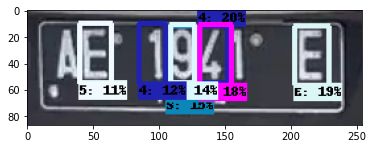

In [ ]:
# visualize detection result
label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=8,
            min_score_thresh=0.05,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 10. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

python Tensorflow\models\research\object_detection\exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\export


In [ ]:
!{command}

2021-04-03 11:51:42.281339: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:51:44.712115: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-03 11:51:44.712813: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-04-03 11:51:44.734951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2b:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.785GHz coreCount: 40 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 417.29GiB/s
2021-04-03 11:51:44.734976: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-04-03 11:51:44.738520: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cublas64_11.dll
202

# 11. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.copy("models.tar.gz", "/content/drive/MyDrive/Bangkit 2021/Capstone/models.tar.gz")

'/content/drive/MyDrive/Bangkit 2021/Capstone/models.tar.gz'